## Google Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Ingest and Basic Exploration

In [2]:
df = pd.read_csv('../data/csv/googl.csv')
df.describe()

,close,high,low,open,transactions,volume,volume_weighted
count,575074.000000,575074.000000,575074.000000,575074.000000,575072.000000,573739.000000,575072.000000
mean,94.507900,94.544323,94.471300,94.508172,287.290169,62531.892899,94.004952
std,28.577722,28.585930,28.569241,28.577806,469.236351,83260.783646,28.582484
min,48.850000,48.860500,48.840500,48.850000,1.000000,0.000000,48.000000
25%,66.433850,66.456125,66.411500,66.434775,62.000000,18900.000000,66.000000
50%,95.870000,95.910000,95.820000,95.868650,139.000000,40120.000000,95.000000
75%,118.011500,118.052000,117.975000,118.011500,337.000000,75280.000000,118.000000
max,152.900000,152.900000,152.900000,152.900000,27020.000000,999052.000000,215.000000


In [3]:
df.shape

(575074, 9)

In [4]:
df.isnull().any()

symbol             False
timestamp          False
close              False
high               False
low                False
open               False
transactions        True
volume              True
volume_weighted     True
dtype: bool

### Basic Plot Explorations

In [5]:
df.set_index("timestamp", inplace=True)
df.head()

,symbol,close,high,low,open,transactions,volume,volume_weighted
timestamp,,,,,,,,
2018-09-06 20:00:00,GOOGL,60.0000,60.0000,60.0000,60.0000,7.0,4620.0,60.0
2018-09-06 20:53:00,GOOGL,60.0100,60.0100,60.0100,60.0100,1.0,6000.0,60.0
2018-09-06 20:54:00,GOOGL,60.0150,60.0150,60.0100,60.0100,8.0,9940.0,60.0
2018-09-06 21:00:00,GOOGL,59.9995,59.9995,59.9995,59.9995,11.0,4980.0,60.0
2018-09-06 21:03:00,GOOGL,59.9690,59.9690,59.9690,59.9690,4.0,6760.0,59.0


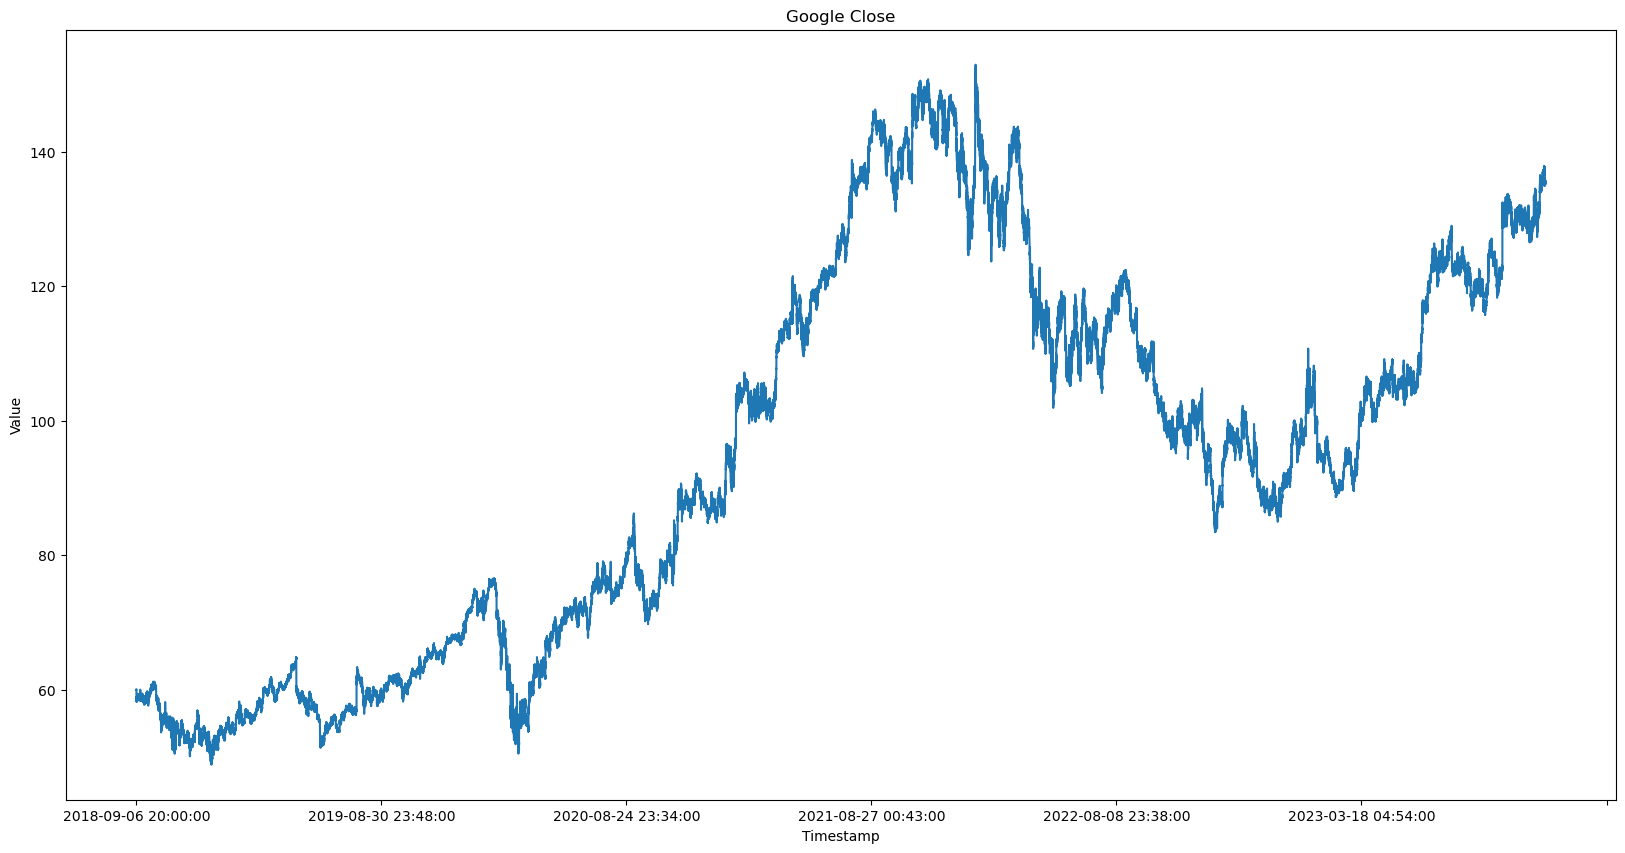

In [6]:
df['close'].plot(kind='line', figsize=(20, 10))
plt.title('Google Close')
plt.ylabel('Value')
plt.xlabel('Timestamp')
plt.show()

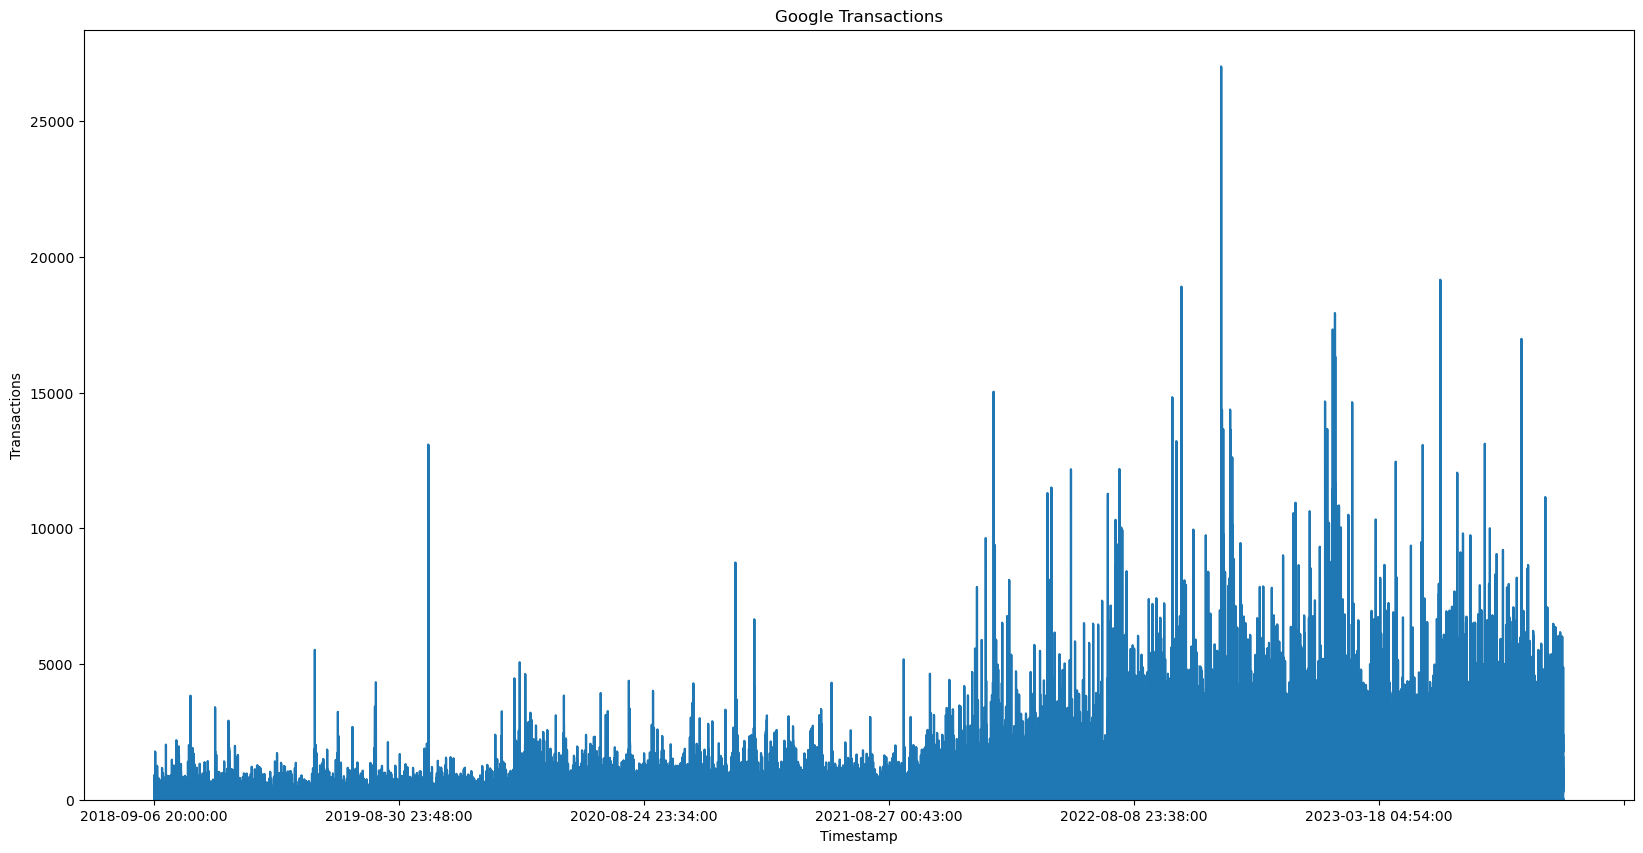

In [7]:
df['transactions'].plot(kind='area', stacked=True, figsize=(20, 10))
plt.title('Google Transactions')
plt.ylabel('Transactions')
plt.xlabel('Timestamp')
plt.show()

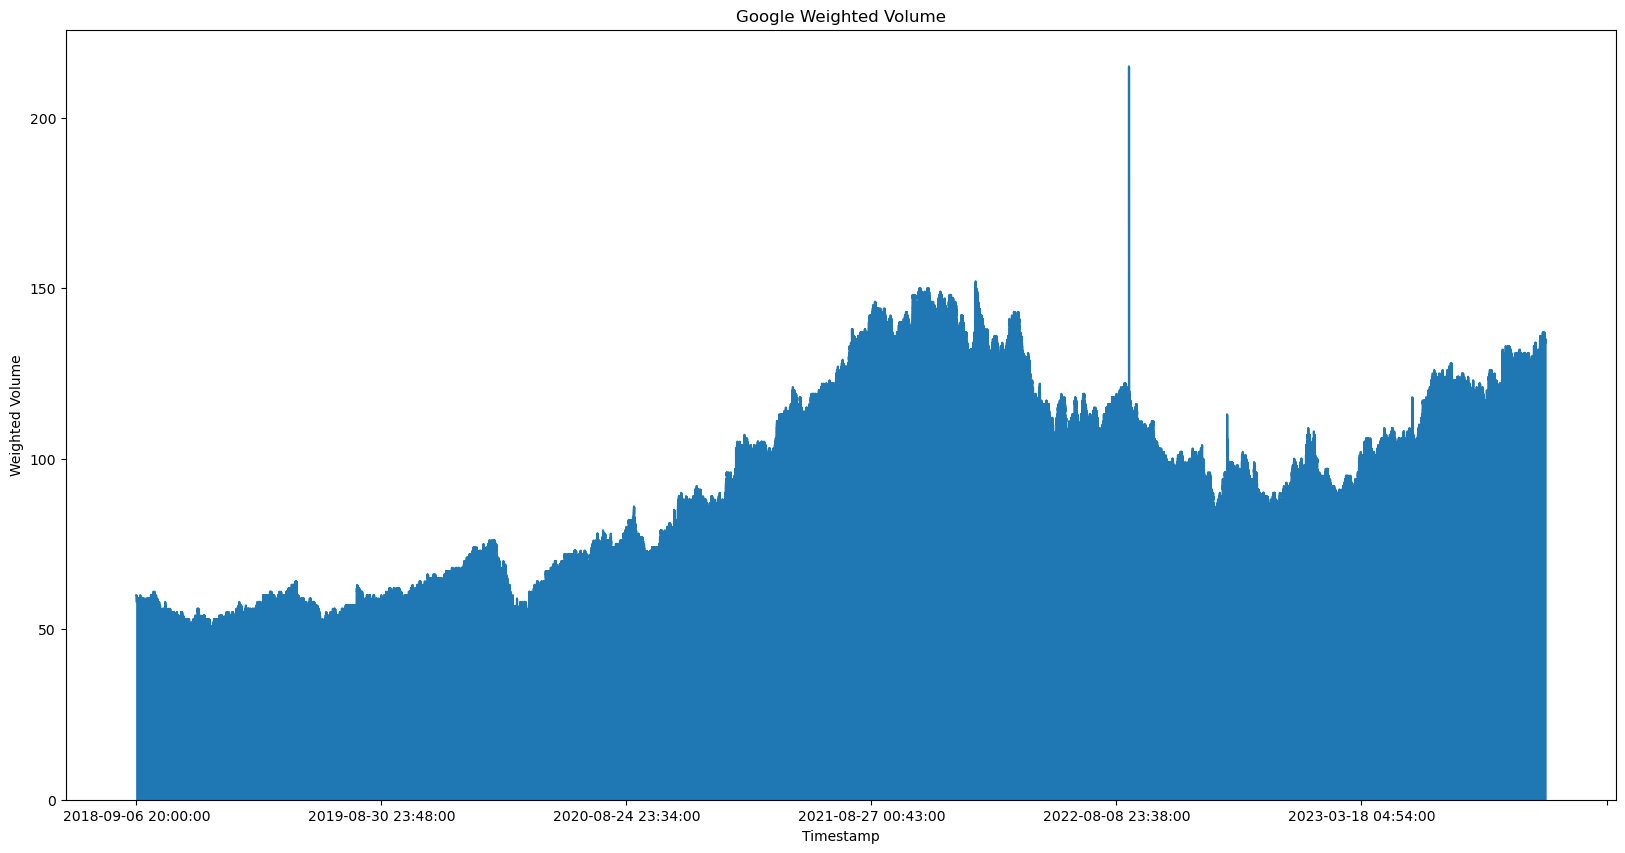

In [8]:
df['volume_weighted'].plot(kind='area', stacked=True, figsize=(20, 10))
plt.title('Google Weighted Volume')
plt.ylabel('Weighted Volume')
plt.xlabel('Timestamp')
plt.show()

### Statistics Exploration

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

Text(0.5, 1.0, 'Mean over Time')

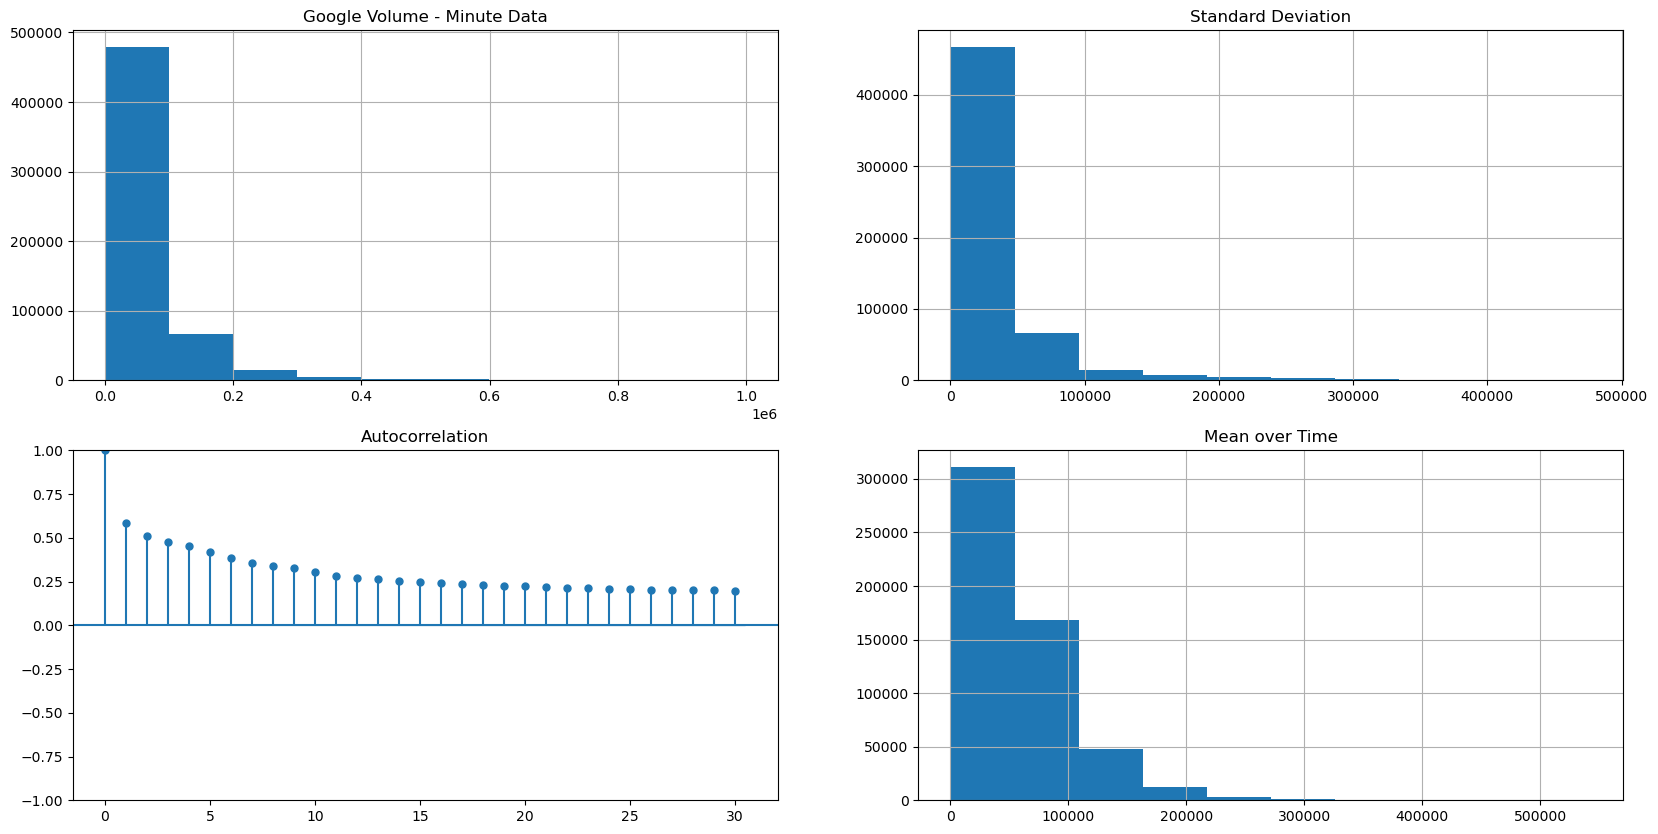

In [10]:
fig = plt.figure(figsize=(20,10))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

df.volume.hist(ax=hist_ax)
hist_ax.set_title('Google Volume - Minute Data')

series = df['volume'].dropna()

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title('Autocorrelation')

mm = df.volume.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title('Standard Deviation')

mm = df.volume.rolling(30).mean()
mm.hist(ax=mean_ax)
mean_ax.set_title('Mean over Time')

### Stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller

# X = df['volume'].dropna().values
# result = adfuller(X)

Unfortunately ADF computation crashed as we are dealing with a large dataset for off the shelf Pandas to process.
As Spark unfortunately does not to my knoweledge offer off-the-shelf ADF testing functions, we will use random sampling as a proxy guide.

In [12]:
def run_adf_on_samples(df, column_name, n_samples, sample_fraction, random_seed=None):
    adf_results = []
    
    for i in range(n_samples):
        # Generate a random sample
        sample_df = df[column_name].dropna().sample(frac=sample_fraction, random_state=random_seed)
        
        # Run the ADF test
        result = adfuller(sample_df)
        
        # Store the result
        adf_results.append({
            'Sample': i + 1,
            'ADF_Statistic': result[0],
            'p-value': "{:.10f}".format(result[1]),
            'Critical_Values': result[4]
        })
        
        print(f"Completed ADF test for sample {i + 1}")

    return adf_results

adf_results = run_adf_on_samples(df, 'volume', 5, 0.1)

Completed ADF test for sample 1
Completed ADF test for sample 2
Completed ADF test for sample 3
Completed ADF test for sample 4
Completed ADF test for sample 5


In [13]:
for res in adf_results:
    print(f"\nSample {res['Sample']}")
    print(f"ADF Statistic: {res['ADF_Statistic']}")
    print(f"p-value: {res['p-value']}")
    print("Critical Values:")
    for key, value in res['Critical_Values'].items():
        print(f"\t{key}: {value}")


Sample 1
ADF Statistic: -238.75572451305143
p-value: 0.0000000000
Critical Values:
	1%: -3.430463983800756
	5%: -2.861590378641695
	10%: -2.566796814859957

Sample 2
ADF Statistic: -240.0343109613561
p-value: 0.0000000000
Critical Values:
	1%: -3.430463983800756
	5%: -2.861590378641695
	10%: -2.566796814859957

Sample 3
ADF Statistic: -75.34520309631282
p-value: 0.0000000000
Critical Values:
	1%: -3.4304640016847965
	5%: -2.861590386545944
	10%: -2.56679681906715

Sample 4
ADF Statistic: -105.19657733565533
p-value: 0.0000000000
Critical Values:
	1%: -3.4304639917485256
	5%: -2.861590382154388
	10%: -2.5667968167296578

Sample 5
ADF Statistic: -240.69298518978877
p-value: 0.0000000000
Critical Values:
	1%: -3.430463983800756
	5%: -2.861590378641695
	10%: -2.566796814859957


Fortunately seems stationary (by using an average as proxy) so no additional methods needed to achieve it